Spectra - single obs, avg obs, rand obs, log regression

  Found 354 observations in file


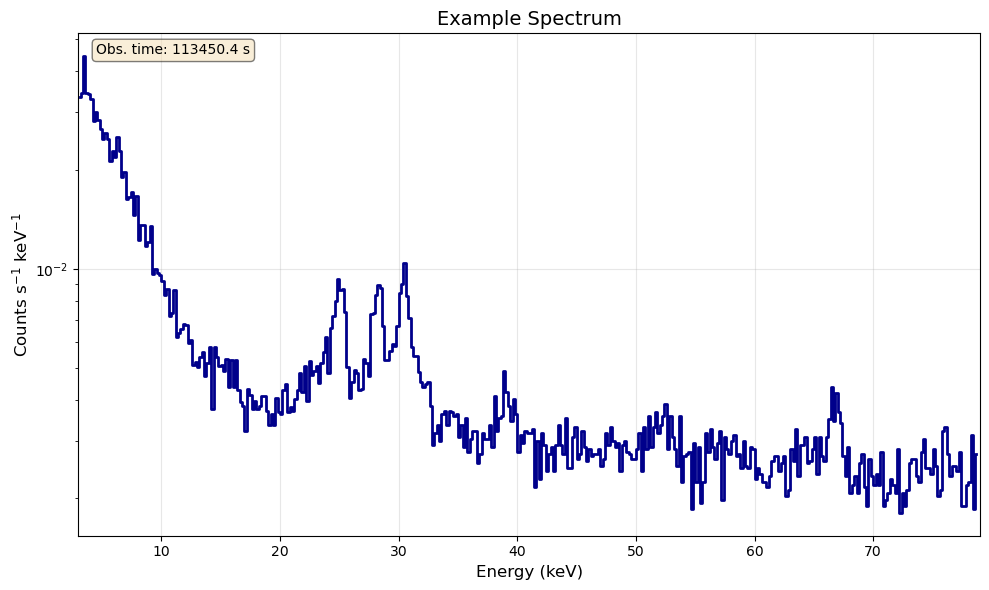

In [14]:
#spectra, one obsevation at a time
def load_nustar_h5(filepath):
    observations = []
    
    with h5py.File(filepath, 'r') as f:  # <-- FIXED: was complete_dataset.h5
        top_level_keys = list(f.keys())
        
        # Check if file has observation datasets
        obs_keys = [k for k in top_level_keys if k.startswith('observation')]
        
        if len(obs_keys) > 0:
            print(f"  Found {len(obs_keys)} observations in file")
            
            # File has observation datasets
            for obs_key in obs_keys:
                obs_data_array = f[obs_key][:]  # Shape: (n_photons, 4)
                
                # Extract columns: [X, Y, TIME, PI]
                x = obs_data_array[:, 0]
                y = obs_data_array[:, 1]
                time = obs_data_array[:, 2]
                pi = obs_data_array[:, 3]
                
                obs_data = {
                    'time': time,
                    'pi': pi,
                    'x': x,
                    'y': y
                }
                
                observations.append(obs_data)
        else:
            # Try flat structure
            print("  No observation groups found, trying flat structure...")
            if len(top_level_keys) > 0:
                data_array = f[top_level_keys[0]][:]
                
                if data_array.ndim == 2 and data_array.shape[1] == 4:
                    x = data_array[:, 0]
                    y = data_array[:, 1]
                    time = data_array[:, 2]
                    pi = data_array[:, 3]
                    
                    obs_data = {
                        'time': time,
                        'pi': pi,
                        'x': x,
                        'y': y
                    }
                    observations.append(obs_data)
                else:
                    raise ValueError(f"Unexpected data shape: {data_array.shape}")
    
    return observations

#Plot X-ray spectrum normalized to counts/s/keV (what hersarc has)   
def plot_spectrum(time, pi, title='NuSTAR Spectrum', energy_range=(3, 79)):
    energy = pi * 0.04 + 1.6
    
    # Filter energy range
    mask = (energy >= energy_range[0]) & (energy <= energy_range[1])
    energy_filtered = energy[mask]
    
    # Calculate observation time
    obs_time = time.max() - time.min()  # Total observation duration in seconds
    
    # Create spectrum
    bin_width = 0.2  # keV
    bins = np.arange(energy_range[0], energy_range[1], bin_width)
    counts, bin_edges = np.histogram(energy_filtered, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Normalize: counts / (bin_width * obs_time)
    count_rate = counts / (bin_width * obs_time)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.step(bin_centers, count_rate, where='mid', linewidth=2, color='darkblue')
    ax.set_xlabel('Energy (keV)', fontsize=12)
    ax.set_ylabel('Counts s$^{-1}$ keV$^{-1}$', fontsize=12)  # Updated label
    ax.set_title(title, fontsize=14)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(energy_range)
    
    # Optional: add text showing observation time
    ax.text(0.02, 0.98, f'Obs. time: {obs_time:.1f} s', 
            transform=ax.transAxes, va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

# file path(s) and load the data
file_list = ['complete_dataset.h5']  

# Load and plot
observations = load_nustar_h5(file_list[0])
first_obs = observations[0]  # Get first observation
    
fig = plot_spectrum(first_obs['time'], first_obs['pi'], title='Example Spectrum')
plt.show()

Processing complete_dataset.h5...
  Found 354 observations in file
Total observations loaded: 354

=== Summary ===
Black hole observations: 274
Pulsar observations: 79

Key spectral differences:
  Mean ratio at 5 keV: 1.11
  Mean ratio at 30 keV: 1.25
  Mean ratio at 60 keV: 0.89


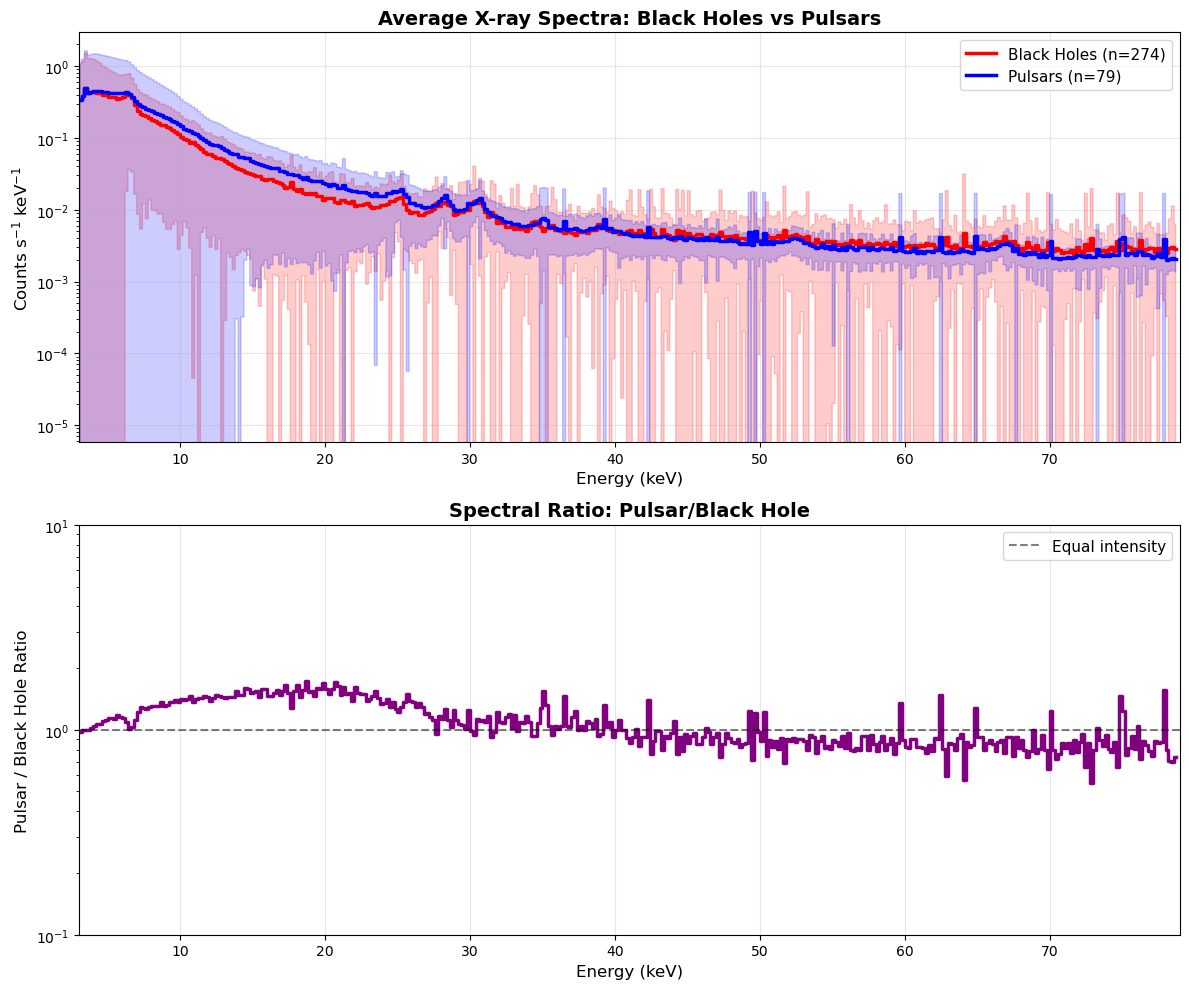

In [16]:
#comparing every bh vs every pulsar and averaging
def compare_averaged_spectra_single_file(filepath, bh_indices, pulsar_indices, 
                                         energy_range=(3, 79), bin_width=0.2):
     bh_spectra = []
    pulsar_spectra = []
    
    print(f"Processing {filepath}...")
    observations = load_nustar_h5(filepath)
    print(f"Total observations loaded: {len(observations)}")
    
    for obs_idx, obs_data in enumerate(observations):
        time = obs_data['time']
        pi = obs_data['pi']
        
        if len(time) < 100:
            continue
        
        try:
            bin_centers, count_rate = create_normalized_spectrum(
                time, pi, energy_range, bin_width
            )
            
            # Classify based on index
            if obs_idx in bh_indices:
                bh_spectra.append(count_rate)
            elif obs_idx in pulsar_indices:
                pulsar_spectra.append(count_rate)
                
        except Exception as e:
            print(f"  Error in observation {obs_idx}: {e}")
            continue
    
    # Convert to arrays
    bh_spectra = np.array(bh_spectra)
    pulsar_spectra = np.array(pulsar_spectra)
    
    bh_mean = np.mean(bh_spectra, axis=0)
    bh_std = np.std(bh_spectra, axis=0)
    
    pulsar_mean = np.mean(pulsar_spectra, axis=0)
    pulsar_std = np.std(pulsar_spectra, axis=0)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Top panel: Both spectra
    ax1.step(bin_centers, bh_mean, where='mid', linewidth=2.5, 
             color='red', label=f'Black Holes (n={len(bh_spectra)})')
    ax1.fill_between(bin_centers, bh_mean - bh_std, bh_mean + bh_std,
                      color='red', alpha=0.2, step='mid')
    
    ax1.step(bin_centers, pulsar_mean, where='mid', linewidth=2.5,
             color='blue', label=f'Pulsars (n={len(pulsar_spectra)})')
    ax1.fill_between(bin_centers, pulsar_mean - pulsar_std, pulsar_mean + pulsar_std,
                      color='blue', alpha=0.2, step='mid')
    
    ax1.set_xlabel('Energy (keV)', fontsize=12)
    ax1.set_ylabel('Counts s$^{-1}$ keV$^{-1}$', fontsize=12)
    ax1.set_title('Average X-ray Spectra: Black Holes vs Pulsars', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.set_xlim(energy_range)
    ax1.legend(fontsize=11, loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Bottom panel: Ratio (Pulsar / Black Hole)
    ratio = pulsar_mean / (bh_mean + 1e-10)
    ax2.step(bin_centers, ratio, where='mid', linewidth=2.5, color='purple')
    ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5, linewidth=1.5, label='Equal intensity')
    ax2.set_xlabel('Energy (keV)', fontsize=12)
    ax2.set_ylabel('Pulsar / Black Hole Ratio', fontsize=12)
    ax2.set_title('Spectral Ratio: Pulsar/Black Hole', fontsize=14, fontweight='bold')
    ax2.set_xlim(energy_range)
    ax2.set_ylim([0.1, 10])  # Reasonable range for ratio
    ax2.set_yscale('log')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    print(f"\nSummary")
    print(f"Black hole observations: {len(bh_spectra)}")
    print(f"Pulsar observations: {len(pulsar_spectra)}")
    print(f"\nKey spectral differences:")
    print(f"  Mean ratio at 5 keV: {ratio[np.argmin(np.abs(bin_centers - 5))]:,.2f}")
    print(f"  Mean ratio at 30 keV: {ratio[np.argmin(np.abs(bin_centers - 30))]:,.2f}")
    print(f"  Mean ratio at 60 keV: {ratio[np.argmin(np.abs(bin_centers - 60))]:,.2f}")
    
    return fig, (bh_mean, bh_std, pulsar_mean, pulsar_std, bin_centers)

# Use it with your data
filepath = 'complete_dataset.h5'
bh_indices = range(0, 274)      # Black holes: 0-273
pulsar_indices = range(274, 354) # Pulsars: 274-353

fig, results = compare_averaged_spectra_single_file(
    filepath, bh_indices, pulsar_indices, energy_range=(3, 79)
)
plt.show()

Loading observations from complete_dataset.h5...
  Found 354 observations in file
  Skipping observation 125 (excluded)

=== Sampled ===
Black holes: 5 observations
Pulsars: 5 observations


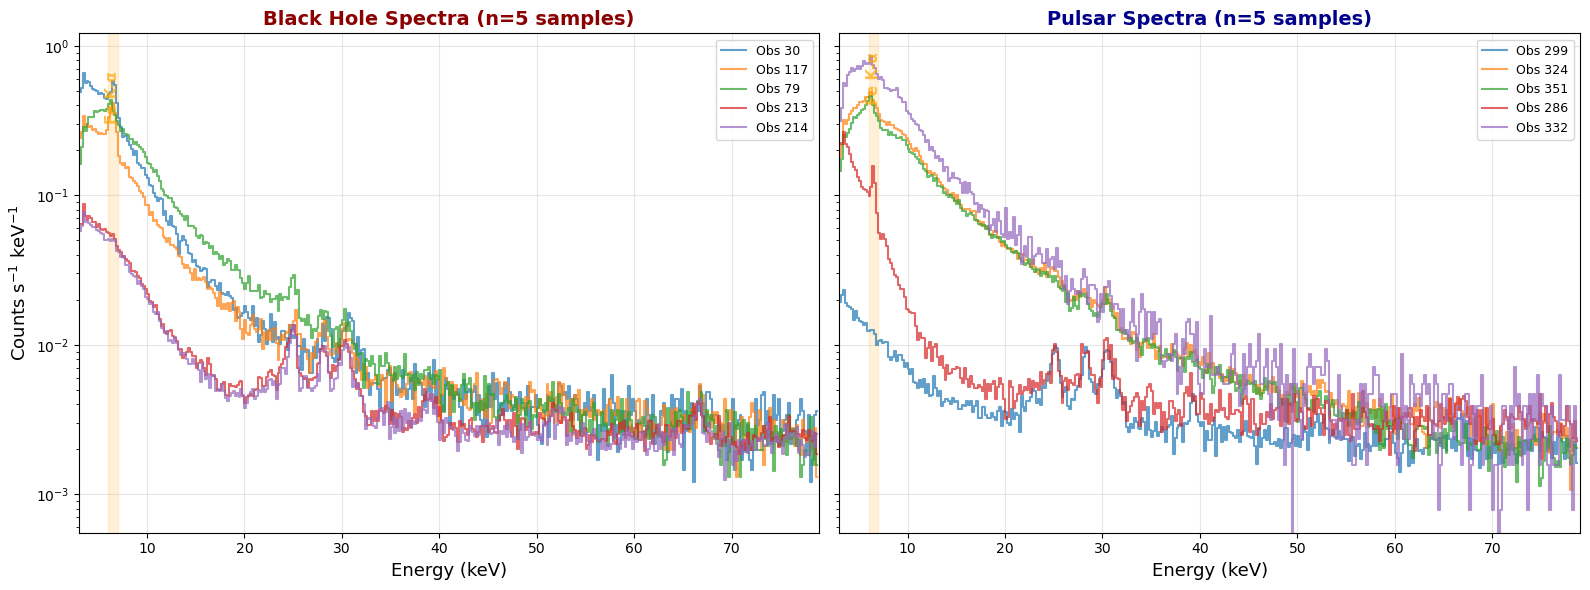

In [22]:
#random obs picked - still spectra

##ban list - obs 125 
#maybe ban - 284
def plot_sample_spectra(filepath, bh_indices, pulsar_indices, 
                        n_samples=5, energy_range=(3, 79), bin_width=0.2, exclude_indices=[125]):

    print(f"Loading observations from {filepath}...")
    observations = load_nustar_h5(filepath)
    
    # Get valid observations for each class
    bh_valid = []
    pulsar_valid = []
    
    for obs_idx, obs_data in enumerate(observations):
        if len(obs_data['time']) < 100:
            continue
        
        # Skip if in ban list
        if obs_idx in exclude_indices:  
            print(f"  Skipping observation {obs_idx} (excluded)")
            continue
            
        if obs_idx in bh_indices:
            bh_valid.append((obs_idx, obs_data))
        elif obs_idx in pulsar_indices:
            pulsar_valid.append((obs_idx, obs_data))
    
    # Randomly sample
    np.random.seed(42)  # For reproducibility
    bh_sample = np.random.choice(len(bh_valid), min(n_samples, len(bh_valid)), replace=False)
    pulsar_sample = np.random.choice(len(pulsar_valid), min(n_samples, len(pulsar_valid)), replace=False)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    # Plot black hole samples
    for i in bh_sample:
        obs_idx, obs_data = bh_valid[i]
        bin_centers, count_rate = create_normalized_spectrum(
            obs_data['time'], obs_data['pi'], energy_range, bin_width
        )
        ax1.step(bin_centers, count_rate, where='mid', linewidth=1.5, 
                 alpha=0.7, label=f'Obs {obs_idx}')
    
    ax1.set_xlabel('Energy (keV)', fontsize=13)
    ax1.set_ylabel('Counts s$^{-1}$ keV$^{-1}$', fontsize=13)
    ax1.set_title(f'Black Hole Spectra (n={len(bh_sample)} samples)', 
                  fontsize=14, fontweight='bold', color='darkred')
    ax1.set_yscale('log')
    ax1.set_xlim(energy_range)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9, loc='upper right')
    
    # Highlight Fe K-alpha region
    ax1.axvspan(6.0, 7.0, alpha=0.15, color='orange', label='Fe K-α region')
    ax1.text(6.5, ax1.get_ylim()[1]*0.5, 'Fe K-α', 
             rotation=90, ha='center', va='center', fontsize=11, 
             color='orange', fontweight='bold', alpha=0.7)
    
    # Plot pulsar samples
    for i in pulsar_sample:
        obs_idx, obs_data = pulsar_valid[i]
        bin_centers, count_rate = create_normalized_spectrum(
            obs_data['time'], obs_data['pi'], energy_range, bin_width
        )
        ax2.step(bin_centers, count_rate, where='mid', linewidth=1.5,
                 alpha=0.7, label=f'Obs {obs_idx}')
    
    ax2.set_xlabel('Energy (keV)', fontsize=13)
    ax2.set_title(f'Pulsar Spectra (n={len(pulsar_sample)} samples)', 
                  fontsize=14, fontweight='bold', color='darkblue')
    ax2.set_yscale('log')
    ax2.set_xlim(energy_range)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9, loc='upper right')
    
    # Highlight Fe K-alpha region
    ax2.axvspan(6.0, 7.0, alpha=0.15, color='orange')
    ax2.text(6.5, ax2.get_ylim()[1]*0.5, 'Fe K-α', 
             rotation=90, ha='center', va='center', fontsize=11,
             color='orange', fontweight='bold', alpha=0.7)
    
    plt.tight_layout()
    
    print(f"\n=== Sampled ===")
    print(f"Black holes: {len(bh_sample)} observations")
    print(f"Pulsars: {len(pulsar_sample)} observations")
    
    return fig

# Create the plot
filepath = 'complete_dataset.h5'
bh_indices = range(0, 274)
pulsar_indices = range(274, 354)

fig = plot_sample_spectra(filepath, bh_indices, pulsar_indices, 
                          n_samples=5, energy_range=(3, 79), exclude_indices=[125])
plt.show()

Extracting spectral features from complete_dataset.h5...
  Found 354 observations in file

Dataset created:
  Total observations: 353
  Black holes: 274
  Pulsars: 79
  Feature dimension: 151 energy bins

Train set: 282 observations
Test set: 71 observations

Training Logistic Regression...

Logistic Regression Results:
              precision    recall  f1-score   support

  Black Hole       0.85      0.93      0.89        55
      Pulsar       0.64      0.44      0.52        16

    accuracy                           0.82        71
   macro avg       0.74      0.68      0.70        71
weighted avg       0.80      0.82      0.80        71

ROC-AUC Score: 0.7534


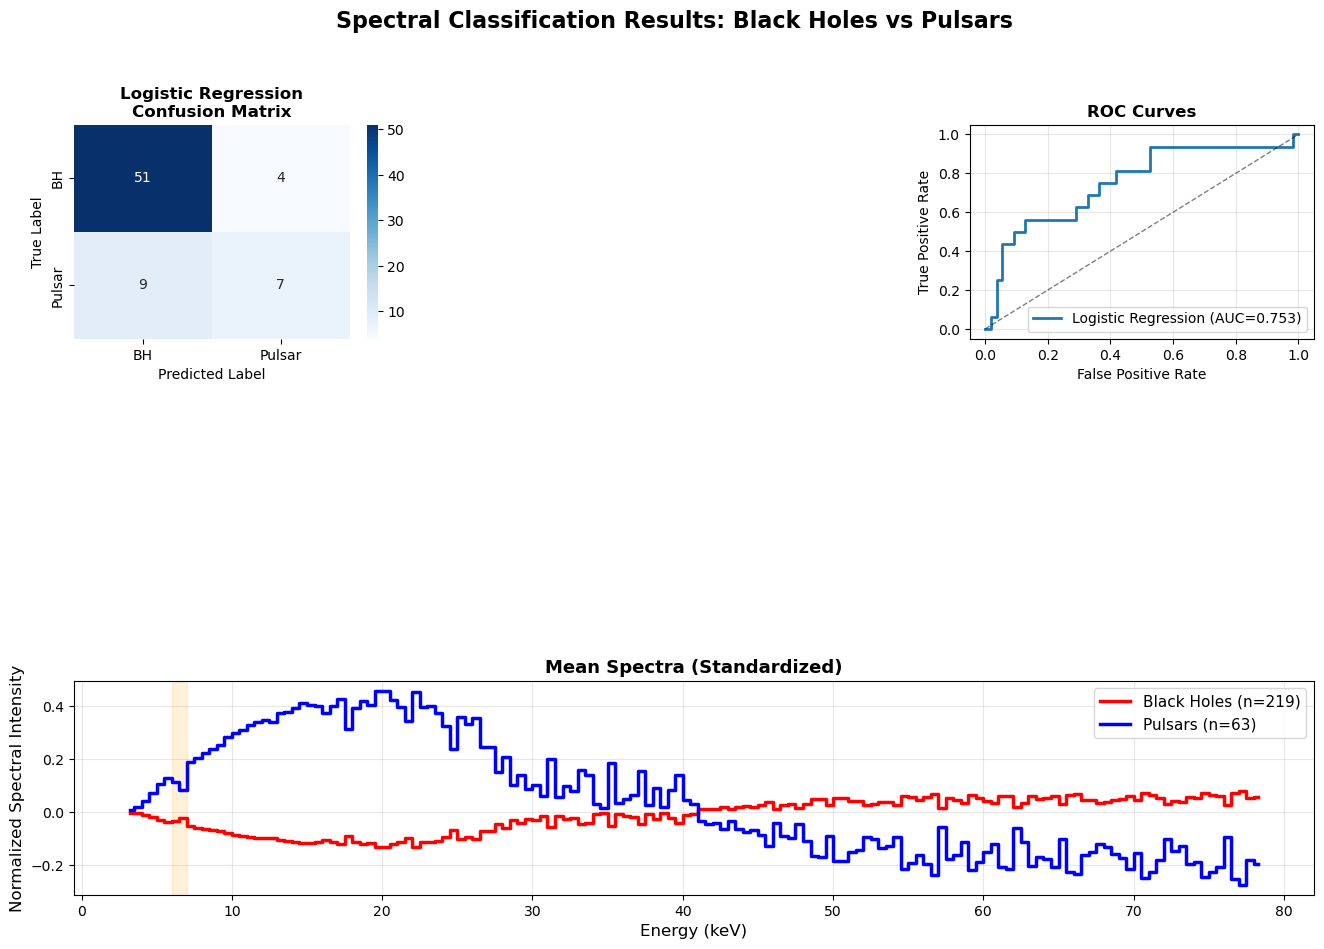

In [21]:
#training on spectra!!
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

def extract_spectral_features(filepath, bh_indices, pulsar_indices, 
                              energy_range=(3, 79), bin_width=0.5):

    print(f"Extracting spectral features from {filepath}...")
    observations = load_nustar_h5(filepath)
    
    X = []
    y = []
    valid_indices = []
    
    # Define energy bins
    bins = np.arange(energy_range[0], energy_range[1], bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    for obs_idx, obs_data in enumerate(observations):
        time = obs_data['time']
        pi = obs_data['pi']
        
        # Skip if too few photons
        if len(time) < 100:
            continue
        
        # Determine label
        if obs_idx in bh_indices:
            label = 0
        elif obs_idx in pulsar_indices:
            label = 1
        else:
            continue  # Skip if not in either category
        
        try:
            # Extract spectrum
            _, count_rate = create_normalized_spectrum(
                time, pi, energy_range, bin_width
            )
            
            X.append(count_rate)
            y.append(label)
            valid_indices.append(obs_idx)
            
        except Exception as e:
            print(f"  Error in observation {obs_idx}: {e}")
            continue
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nDataset created:")
    print(f"  Total observations: {len(X)}")
    print(f"  Black holes: {np.sum(y == 0)}")
    print(f"  Pulsars: {np.sum(y == 1)}")
    print(f"  Feature dimension: {X.shape[1]} energy bins")
    
    return X, y, bin_centers, valid_indices

 
#Train and evaluate classifiers on spectral data
def train_spectral_classifier(X, y, bin_centers):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    ) #going dif then nolan, can train with same
    
    print(f"\nTrain set: {len(X_train)} observations")
    print(f"Test set: {len(X_test)} observations")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train classifier
    classifier = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
    }
    
    results = {}
    
    for name, clf in classifier.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        
        # Train
        clf.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
        
        # Evaluate
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred, 
                                   target_names=['Black Hole', 'Pulsar']))
        
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC-AUC Score: {auc:.4f}")
        
        results[name] = {
            'model': clf,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'auc': auc
        }
    
    return results, X_train_scaled, X_test_scaled, y_train, y_test, scaler

#viz
def plot_classification_results(results, y_test, bin_centers, X_train_scaled, y_train):
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
#Confusion matrices
    for idx, (name, result) in enumerate(results.items()):
        ax = fig.add_subplot(gs[0, idx])
        cm = confusion_matrix(y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['BH', 'Pulsar'],
                   yticklabels=['BH', 'Pulsar'])
        ax.set_title(f'{name}\nConfusion Matrix', fontweight='bold')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
#ROC Curves
    ax_roc = fig.add_subplot(gs[0, 2])
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        ax_roc.plot(fpr, tpr, linewidth=2, 
                   label=f"{name} (AUC={result['auc']:.3f})")
    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curves', fontweight='bold')
    ax_roc.legend()
    ax_roc.grid(True, alpha=0.3)
       
#Average spectra by class
    ax_spec = fig.add_subplot(gs[2, :])
    
    # Compute mean spectra for train set
    bh_mask = y_train == 0
    pulsar_mask = y_train == 1
    
    bh_mean = np.mean(X_train_scaled[bh_mask], axis=0)
    pulsar_mean = np.mean(X_train_scaled[pulsar_mask], axis=0)
    
    ax_spec.step(bin_centers, bh_mean, where='mid', linewidth=2.5,
                color='red', label=f'Black Holes (n={np.sum(bh_mask)})')
    ax_spec.step(bin_centers, pulsar_mean, where='mid', linewidth=2.5,
                color='blue', label=f'Pulsars (n={np.sum(pulsar_mask)})')
    
    ax_spec.set_xlabel('Energy (keV)', fontsize=12)
    ax_spec.set_ylabel('Normalized Spectral Intensity', fontsize=12)
    ax_spec.set_title('Mean Spectra (Standardized)', fontsize=13, fontweight='bold')
    ax_spec.legend(fontsize=11)
    ax_spec.grid(True, alpha=0.3)
    ax_spec.axvspan(6.0, 7.0, alpha=0.15, color='orange')
    
    plt.suptitle('Spectral Classification Results: Black Holes vs Pulsars',
                fontsize=16, fontweight='bold', y=0.995)
    
    return fig

# Extract features
filepath = 'complete_dataset.h5'
bh_indices = range(0, 274)
pulsar_indices = range(274, 354)

X, y, bin_centers, valid_indices = extract_spectral_features(
    filepath, bh_indices, pulsar_indices, 
    energy_range=(3, 79), bin_width=0.5
)

# Train classifiers
results, X_train_scaled, X_test_scaled, y_train, y_test, scaler = train_spectral_classifier(
    X, y, bin_centers
)

# Visualize results
fig = plot_classification_results(results, y_test, bin_centers, X_train_scaled, y_train)
plt.show()
